In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [2]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

print("Dataset importato con successo")

Dataset importato con successo


Total :  13451
Normal :  7500
Malicious :  5951


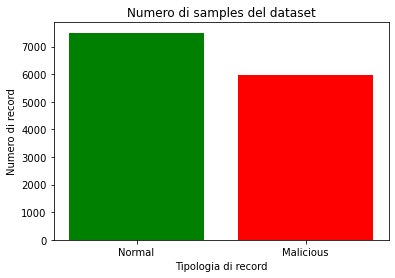

In [3]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [4]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

In [5]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')

data.flag.replace(flag_list, range(len(flag_list)), inplace=True)


data.result.replace(['dos','normal','probe','r2l','u2r'], range(5), inplace=True)


Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [6]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Conversione feature "count" in linguaggio macchina . . .')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Conversione indici 1,2,3 in linguaggio macchina . . .')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Rimuovo le features di indici 1,2,3 e concateno un hot encoder array')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print("")
print("")
print('Final shape of data:', data_final.shape)
print("")
print("")

Conversione feature "count" in linguaggio macchina . . .
Conversione indici 1,2,3 in linguaggio macchina . . .
Rimuovo le features di indici 1,2,3 e concateno un hot encoder array


Final shape of data: (13451, 95)




Epoch 1/30
48/48 [==============================] - 7s 154ms/step - loss: 3.4707 - accuracy: 0.8626 - val_loss: 1.4662 - val_accuracy: 0.9500
Epoch 2/30
48/48 [==============================] - 6s 128ms/step - loss: 0.9123 - accuracy: 0.9466 - val_loss: 0.5779 - val_accuracy: 0.9650
Epoch 3/30
48/48 [==============================] - 6s 125ms/step - loss: 0.5310 - accuracy: 0.9297 - val_loss: 0.3171 - val_accuracy: 0.9700
Epoch 4/30
48/48 [==============================] - 6s 130ms/step - loss: 0.3391 - accuracy: 0.9604 - val_loss: 0.2502 - val_accuracy: 0.9750
Epoch 5/30
48/48 [==============================] - 7s 137ms/step - loss: 0.2820 - accuracy: 0.9660 - val_loss: 0.1867 - val_accuracy: 0.9750
Epoch 6/30
48/48 [==============================] - 6s 132ms/step - loss: 0.2268 - accuracy: 0.9678 - val_loss: 0.1893 - val_accuracy: 0.9750
Epoch 7/30
48/48 [==============================] - 7s 136ms/step - loss: 0.2191 - accuracy: 0.9650 - val_loss: 0.1825 - val_accuracy: 0.9750
Epoch 

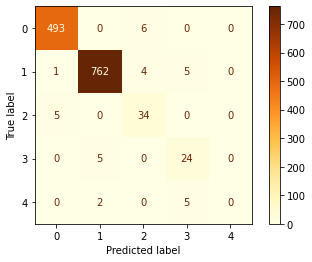

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       499
           1       0.99      0.99      0.99       772
           2       0.77      0.87      0.82        39
           3       0.71      0.83      0.76        29
           4       0.00      0.00      0.00         7

    accuracy                           0.98      1346
   macro avg       0.69      0.73      0.71      1346
weighted avg       0.97      0.98      0.97      1346

### 0 Anomaly / 1 Normal ###


C:\Users\39331\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


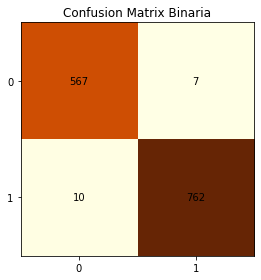

          predicted labels  
0 :
             precision:  0.983
             recall:     0.988


1 :
             precision:  0.991
             recall:     0.987


Accuracy:  0.98737
Epoch 1/30
48/48 [==============================] - 7s 137ms/step - loss: 3.6092 - accuracy: 0.8125 - val_loss: 1.5765 - val_accuracy: 0.9650
Epoch 2/30
48/48 [==============================] - 6s 132ms/step - loss: 1.0042 - accuracy: 0.9447 - val_loss: 0.7341 - val_accuracy: 0.9450
Epoch 3/30
48/48 [==============================] - 6s 132ms/step - loss: 0.4993 - accuracy: 0.9444 - val_loss: 0.2965 - val_accuracy: 0.9750
Epoch 4/30
48/48 [==============================] - 7s 135ms/step - loss: 0.3100 - accuracy: 0.9627 - val_loss: 0.2753 - val_accuracy: 0.9800
Epoch 5/30
48/48 [==============================] - 6s 132ms/step - loss: 0.2612 - accuracy: 0.9650 - val_loss: 0.1773 - val_accuracy: 0.9850
Epoch 6/30
48/48 [==============================] - 7s 136ms/step - loss: 0.2370 - accuracy: 0.9600 - val_

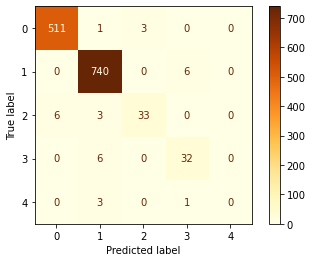

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       515
           1       0.98      0.99      0.99       746
           2       0.92      0.79      0.85        42
           3       0.82      0.84      0.83        38
           4       0.00      0.00      0.00         4

    accuracy                           0.98      1345
   macro avg       0.74      0.72      0.73      1345
weighted avg       0.98      0.98      0.98      1345

### 0 Anomaly / 1 Normal ###


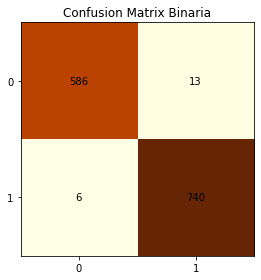

          predicted labels  
0 :
             precision:  0.990
             recall:     0.978


1 :
             precision:  0.983
             recall:     0.992


Accuracy:  0.98587
Epoch 1/30
48/48 [==============================] - 7s 136ms/step - loss: 3.5293 - accuracy: 0.8378 - val_loss: 1.4136 - val_accuracy: 0.9400
Epoch 2/30
48/48 [==============================] - 6s 132ms/step - loss: 0.8939 - accuracy: 0.9456 - val_loss: 0.4914 - val_accuracy: 0.9750
Epoch 3/30
48/48 [==============================] - 6s 134ms/step - loss: 0.4165 - accuracy: 0.9615 - val_loss: 0.2729 - val_accuracy: 0.9700
Epoch 4/30
48/48 [==============================] - 6s 134ms/step - loss: 0.2953 - accuracy: 0.9643 - val_loss: 0.2134 - val_accuracy: 0.9800
Epoch 5/30
48/48 [==============================] - 7s 136ms/step - loss: 0.2544 - accuracy: 0.9623 - val_loss: 0.1955 - val_accuracy: 0.9800
Epoch 6/30
48/48 [==============================] - 6s 132ms/step - loss: 0.2137 - accuracy: 0.9685 - val_

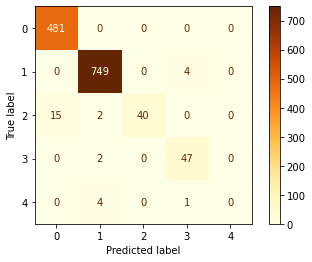

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       481
           1       0.99      0.99      0.99       753
           2       1.00      0.70      0.82        57
           3       0.90      0.96      0.93        49
           4       0.00      0.00      0.00         5

    accuracy                           0.98      1345
   macro avg       0.77      0.73      0.75      1345
weighted avg       0.98      0.98      0.98      1345

### 0 Anomaly / 1 Normal ###


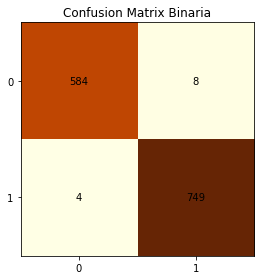

          predicted labels  
0 :
             precision:  0.993
             recall:     0.986


1 :
             precision:  0.989
             recall:     0.995


Accuracy:  0.99108
Epoch 1/30
48/48 [==============================] - 6s 135ms/step - loss: 3.6649 - accuracy: 0.8070 - val_loss: 1.5236 - val_accuracy: 0.9700
Epoch 2/30
48/48 [==============================] - 6s 135ms/step - loss: 0.9635 - accuracy: 0.9461 - val_loss: 0.4643 - val_accuracy: 0.9700
Epoch 3/30
48/48 [==============================] - 6s 131ms/step - loss: 0.4517 - accuracy: 0.9509 - val_loss: 0.2804 - val_accuracy: 0.9750
Epoch 4/30
48/48 [==============================] - 6s 134ms/step - loss: 0.3188 - accuracy: 0.9598 - val_loss: 0.5173 - val_accuracy: 0.8750
Epoch 5/30
48/48 [==============================] - 6s 133ms/step - loss: 0.2691 - accuracy: 0.9646 - val_loss: 0.1899 - val_accuracy: 0.9850
Epoch 6/30
48/48 [==============================] - 6s 131ms/step - loss: 0.2246 - accuracy: 0.9684 - val_

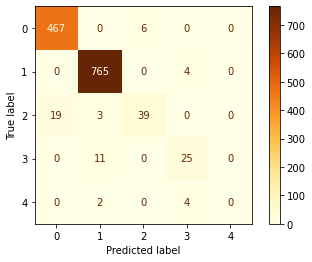

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       473
           1       0.98      0.99      0.99       769
           2       0.87      0.64      0.74        61
           3       0.76      0.69      0.72        36
           4       0.00      0.00      0.00         6

    accuracy                           0.96      1345
   macro avg       0.71      0.66      0.68      1345
weighted avg       0.96      0.96      0.96      1345

### 0 Anomaly / 1 Normal ###


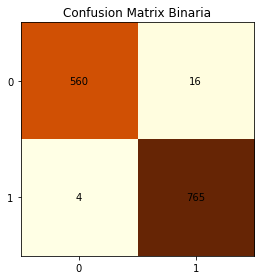

          predicted labels  
0 :
             precision:  0.993
             recall:     0.972


1 :
             precision:  0.980
             recall:     0.995


Accuracy:  0.98513
Epoch 1/30
48/48 [==============================] - 6s 135ms/step - loss: 3.5245 - accuracy: 0.8157 - val_loss: 1.4630 - val_accuracy: 0.9650
Epoch 2/30
48/48 [==============================] - 6s 131ms/step - loss: 0.9261 - accuracy: 0.9271 - val_loss: 0.4434 - val_accuracy: 0.9700
Epoch 3/30
48/48 [==============================] - 7s 136ms/step - loss: 0.4205 - accuracy: 0.9483 - val_loss: 0.2655 - val_accuracy: 0.9750
Epoch 4/30
48/48 [==============================] - 6s 131ms/step - loss: 0.3484 - accuracy: 0.9528 - val_loss: 0.2114 - val_accuracy: 0.9800
Epoch 5/30
48/48 [==============================] - 6s 133ms/step - loss: 0.2548 - accuracy: 0.9683 - val_loss: 0.1791 - val_accuracy: 0.9800
Epoch 6/30
48/48 [==============================] - 6s 134ms/step - loss: 0.2356 - accuracy: 0.9689 - val_

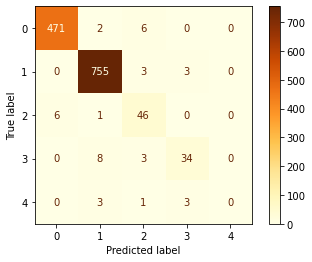

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       479
           1       0.98      0.99      0.99       761
           2       0.78      0.87      0.82        53
           3       0.85      0.76      0.80        45
           4       0.00      0.00      0.00         7

    accuracy                           0.97      1345
   macro avg       0.72      0.72      0.72      1345
weighted avg       0.97      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


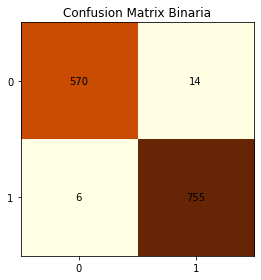

          predicted labels  
0 :
             precision:  0.990
             recall:     0.976


1 :
             precision:  0.982
             recall:     0.992


Accuracy:  0.98513
Epoch 1/30
48/48 [==============================] - 6s 134ms/step - loss: 3.6731 - accuracy: 0.8594 - val_loss: 1.6195 - val_accuracy: 0.9600
Epoch 2/30
48/48 [==============================] - 7s 137ms/step - loss: 1.0376 - accuracy: 0.9453 - val_loss: 0.5156 - val_accuracy: 0.9550
Epoch 3/30
48/48 [==============================] - 6s 133ms/step - loss: 0.4428 - accuracy: 0.9571 - val_loss: 0.2781 - val_accuracy: 0.9700
Epoch 4/30
48/48 [==============================] - 6s 132ms/step - loss: 0.2878 - accuracy: 0.9664 - val_loss: 0.2865 - val_accuracy: 0.9600
Epoch 5/30
48/48 [==============================] - 6s 135ms/step - loss: 0.3057 - accuracy: 0.9537 - val_loss: 0.1927 - val_accuracy: 0.9750
Epoch 6/30
48/48 [==============================] - 6s 131ms/step - loss: 0.2194 - accuracy: 0.9682 - val_

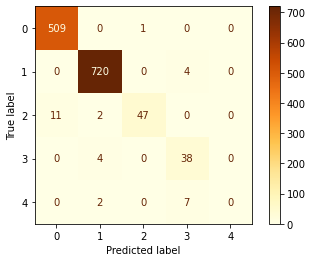

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       510
           1       0.99      0.99      0.99       724
           2       0.98      0.78      0.87        60
           3       0.78      0.90      0.84        42
           4       0.00      0.00      0.00         9

    accuracy                           0.98      1345
   macro avg       0.74      0.74      0.74      1345
weighted avg       0.97      0.98      0.97      1345

### 0 Anomaly / 1 Normal ###


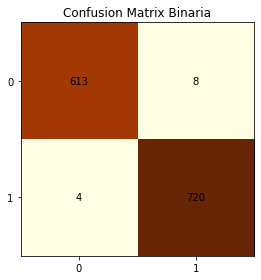

          predicted labels  
0 :
             precision:  0.994
             recall:     0.987


1 :
             precision:  0.989
             recall:     0.994


Accuracy:  0.99108
Epoch 1/30
48/48 [==============================] - 7s 138ms/step - loss: 3.5811 - accuracy: 0.8551 - val_loss: 1.5773 - val_accuracy: 0.9600
Epoch 2/30
48/48 [==============================] - 6s 134ms/step - loss: 0.9741 - accuracy: 0.9437 - val_loss: 0.4969 - val_accuracy: 0.9550
Epoch 3/30
48/48 [==============================] - 6s 132ms/step - loss: 0.4463 - accuracy: 0.9460 - val_loss: 0.3879 - val_accuracy: 0.9350
Epoch 4/30
48/48 [==============================] - 7s 136ms/step - loss: 0.3228 - accuracy: 0.9598 - val_loss: 0.2165 - val_accuracy: 0.9700
Epoch 5/30
48/48 [==============================] - 6s 133ms/step - loss: 0.2584 - accuracy: 0.9637 - val_loss: 0.1846 - val_accuracy: 0.9750
Epoch 6/30
48/48 [==============================] - 6s 135ms/step - loss: 0.2244 - accuracy: 0.9625 - val_

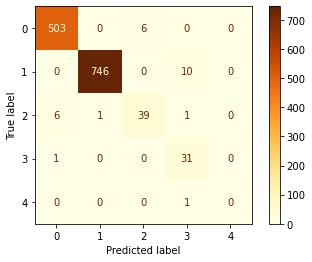

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       509
           1       1.00      0.99      0.99       756
           2       0.87      0.83      0.85        47
           3       0.72      0.97      0.83        32
           4       0.00      0.00      0.00         1

    accuracy                           0.98      1345
   macro avg       0.71      0.75      0.73      1345
weighted avg       0.98      0.98      0.98      1345

### 0 Anomaly / 1 Normal ###


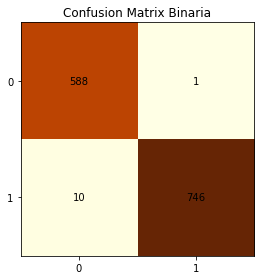

          predicted labels  
0 :
             precision:  0.983
             recall:     0.998


1 :
             precision:  0.999
             recall:     0.987


Accuracy:  0.99182
Epoch 1/30
48/48 [==============================] - 7s 136ms/step - loss: 3.9401 - accuracy: 0.8325 - val_loss: 1.8725 - val_accuracy: 0.9600
Epoch 2/30
48/48 [==============================] - 6s 132ms/step - loss: 1.2651 - accuracy: 0.9427 - val_loss: 0.6272 - val_accuracy: 0.9600
Epoch 3/30
48/48 [==============================] - 7s 136ms/step - loss: 0.5185 - accuracy: 0.9566 - val_loss: 0.2992 - val_accuracy: 0.9750
Epoch 4/30
48/48 [==============================] - 6s 132ms/step - loss: 0.3336 - accuracy: 0.9605 - val_loss: 0.2671 - val_accuracy: 0.9700
Epoch 5/30
48/48 [==============================] - 6s 135ms/step - loss: 0.2906 - accuracy: 0.9534 - val_loss: 0.1964 - val_accuracy: 0.9700
Epoch 6/30
48/48 [==============================] - 6s 133ms/step - loss: 0.2363 - accuracy: 0.9661 - val_

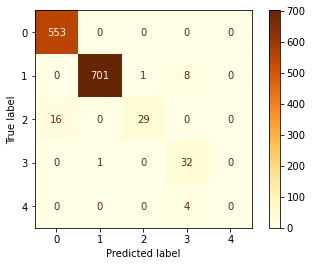

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       553
           1       1.00      0.99      0.99       710
           2       0.97      0.64      0.77        45
           3       0.73      0.97      0.83        33
           4       0.00      0.00      0.00         4

    accuracy                           0.98      1345
   macro avg       0.73      0.72      0.72      1345
weighted avg       0.98      0.98      0.98      1345

### 0 Anomaly / 1 Normal ###


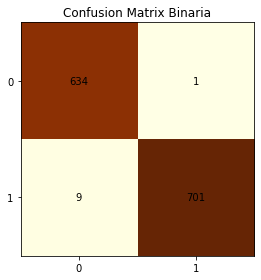

          predicted labels  
0 :
             precision:  0.986
             recall:     0.998


1 :
             precision:  0.999
             recall:     0.987


Accuracy:  0.99257
Epoch 1/30
48/48 [==============================] - 6s 135ms/step - loss: 3.4265 - accuracy: 0.8380 - val_loss: 1.3694 - val_accuracy: 0.9500
Epoch 2/30
48/48 [==============================] - 7s 137ms/step - loss: 0.8807 - accuracy: 0.9437 - val_loss: 0.4299 - val_accuracy: 0.9700
Epoch 3/30
48/48 [==============================] - 6s 134ms/step - loss: 0.4179 - accuracy: 0.9569 - val_loss: 0.4833 - val_accuracy: 0.9150
Epoch 4/30
48/48 [==============================] - 6s 134ms/step - loss: 0.2950 - accuracy: 0.9662 - val_loss: 0.2077 - val_accuracy: 0.9750
Epoch 5/30
48/48 [==============================] - 6s 133ms/step - loss: 0.2416 - accuracy: 0.9674 - val_loss: 0.1911 - val_accuracy: 0.9650
Epoch 6/30
48/48 [==============================] - 6s 132ms/step - loss: 0.2063 - accuracy: 0.9685 - val_

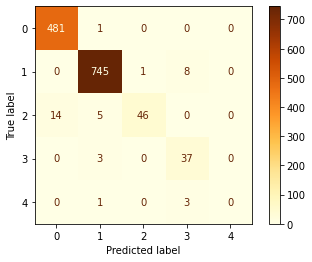

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       482
           1       0.99      0.99      0.99       754
           2       0.98      0.71      0.82        65
           3       0.77      0.93      0.84        40
           4       0.00      0.00      0.00         4

    accuracy                           0.97      1345
   macro avg       0.74      0.72      0.73      1345
weighted avg       0.97      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


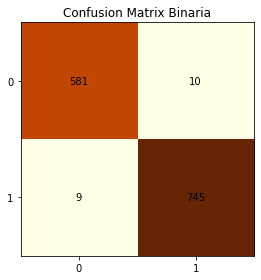

          predicted labels  
0 :
             precision:  0.985
             recall:     0.983


1 :
             precision:  0.987
             recall:     0.988


Accuracy:  0.98587
Epoch 1/30
48/48 [==============================] - 7s 139ms/step - loss: 3.5876 - accuracy: 0.8203 - val_loss: 1.4579 - val_accuracy: 0.9650
Epoch 2/30
48/48 [==============================] - 6s 132ms/step - loss: 1.1593 - accuracy: 0.9031 - val_loss: 0.5929 - val_accuracy: 0.9650
Epoch 3/30
48/48 [==============================] - 6s 135ms/step - loss: 0.5354 - accuracy: 0.9479 - val_loss: 0.3174 - val_accuracy: 0.9650
Epoch 4/30
48/48 [==============================] - 6s 134ms/step - loss: 0.3430 - accuracy: 0.9632 - val_loss: 0.2134 - val_accuracy: 0.9800
Epoch 5/30
48/48 [==============================] - 6s 131ms/step - loss: 0.2932 - accuracy: 0.9547 - val_loss: 0.1767 - val_accuracy: 0.9800
Epoch 6/30
48/48 [==============================] - 7s 136ms/step - loss: 0.2275 - accuracy: 0.9679 - val_

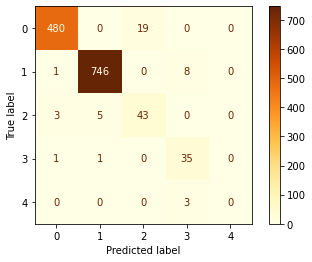

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       499
           1       0.99      0.99      0.99       755
           2       0.69      0.84      0.76        51
           3       0.76      0.95      0.84        37
           4       0.00      0.00      0.00         3

    accuracy                           0.97      1345
   macro avg       0.69      0.75      0.71      1345
weighted avg       0.97      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


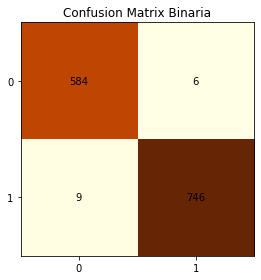

          predicted labels  
0 :
             precision:  0.985
             recall:     0.990


1 :
             precision:  0.992
             recall:     0.988


Accuracy:  0.98885


In [7]:
y = data_final[94]
x = data_final.drop([94], axis=1)

x_np = np.asarray(x).astype(np.float32)
y_np = np.asarray(y).astype(np.float32)

kfold = KFold(n_splits=10, shuffle=True, random_state=32)

for train, test in kfold.split(x_np, y_np):
    x_train, x_test = x_np[train], x_np[test]
    y_train, y_test = y_np[train], y_np[test]
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    val_indices = 200
    x_val = x_train[-val_indices:]
    y_val = y_train[-val_indices:]
    
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    history = model.fit(x_train,
          y_train,
          epochs=30,
          batch_size=256,
          validation_data=(x_val, y_val)
         )
    
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # 0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][0]+conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
          "record Dos di cui",conf_matrix[0][0],"corretti(TP),",
          conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
          "predetti erroneamente(FP),",
          conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[0][3]+conf_matrix[0][4],
          "record Dos reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][1]+conf_matrix[1][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
          "record Normali di cui",conf_matrix[1][1],"corretti(TP),",
          conf_matrix[0][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
          "predetti erroneamente(FP),",
          conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[1][3]+conf_matrix[1][4],
          "record Normali reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[2][2]+conf_matrix[3][2]+conf_matrix[4][2],
          "record Probe di cui",conf_matrix[2][2],"corretti(TP),",
          conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[3][2]+conf_matrix[4][2],
          "predetti erroneamente(FP),",
          conf_matrix[2][0]+conf_matrix[2][1]+conf_matrix[2][3]+conf_matrix[2][4],
          "record Probe reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[3][3]+conf_matrix[4][3],
          "record R2L di cui",conf_matrix[3][3],"corretti(TP),",
          conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[4][3],
          "predetti erroneamente(FP),",
          conf_matrix[3][0]+conf_matrix[3][1]+conf_matrix[3][2]+conf_matrix[3][4],
          "record R2L reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4]+conf_matrix[4][4],
          "record U2R di cui",conf_matrix[4][4],"corretti(TP),",
          conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4],
          "predetti erroneamente(FP),",
          conf_matrix[4][0]+conf_matrix[4][1]+conf_matrix[4][2]+conf_matrix[4][3],
          "record U2R reali predetti in altri attacchi (FN)"
         )

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    disp = disp.plot(cmap='YlOrBr')

    plt.show()
    print("0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r")
    print("")
    print(classification_report(y_test, y_pred))
    
    #Calcolo a posteriori la rispettiva matrice di confusione binaria associata alla precedente

    #num_test_normal / num_test_dos etc . . .
    # 1 è normal mentre 0 2 3 4 sono anomalies

    #Record normali classificati come normali (TP)

    true_positive = conf_matrix[1][1]

    #record anomali classificati come anomali (TN)

    true_negative = (conf_matrix[0][0] + conf_matrix[0][2] + conf_matrix[0][3] + conf_matrix[0][4] +
                    + conf_matrix[2][0] + conf_matrix[2][2] + conf_matrix[2][3] + conf_matrix[2][4] 
                    + conf_matrix[3][0] + conf_matrix[3][2] + conf_matrix[3][3] + conf_matrix[3][4] 
                    + conf_matrix[4][0] + conf_matrix[4][2] + conf_matrix[4][3] + conf_matrix[4][4])
            
    #record normali classificati come anomali (FN)

    false_negative = conf_matrix[1][0] + conf_matrix[1][2] + conf_matrix[1][3] + conf_matrix[1][4]

    #record anomali classificati come normali (FP)

    false_positive = conf_matrix[0][1] + conf_matrix[2][1] + conf_matrix[3][1] + conf_matrix[4][1]

    indici_riga_colonna = ['0','1']


    values = np.array([[true_negative, false_positive],
                       [false_negative, true_positive]])

    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap='YlOrBr')

    ax.set_xticks(np.arange(len(indici_riga_colonna)))
    ax.set_yticks(np.arange(len(indici_riga_colonna)))

    ax.set_xticklabels(indici_riga_colonna)
    ax.set_yticklabels(indici_riga_colonna)

    plt.setp(ax.get_xticklabels(),
         rotation_mode="anchor")

    for i in range(len(indici_riga_colonna)):
        for j in range(len(indici_riga_colonna)):
            text = ax.text(j, i, values[i, j],
                       ha="center", va="center")

    ax.set_title("Confusion Matrix Binaria")
    fig.tight_layout()

    print("### 0 Anomaly / 1 Normal ###")
    plt.show()

    print("          predicted labels  ")

    zero_precision = true_negative/(true_negative + false_negative) 
    one_precision = true_positive/(true_positive + false_positive) 

    zero_recall = true_negative/(true_negative + false_positive)
    one_recall = true_positive/(true_positive + false_negative)

    accuracy= (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    print("0 :")
    print("             precision: ","%.3f" % zero_precision)
    print("             recall: ","   %.3f" % zero_recall)
    print("")
    print("")
    print("1 :")
    print("             precision: ","%.3f" % one_precision)
    print("             recall: ","   %.3f" % one_recall)
    print("")
    print("")
    print("Accuracy: ", "%.5f" % accuracy)